In [4]:
#Utility
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS as wc_stp

#Sklearn
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as tvect
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn . decomposition import PCA
##Metrics and Testing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
##Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
df = pd.read_csv('datasets/final_bullying_dataset.csv')

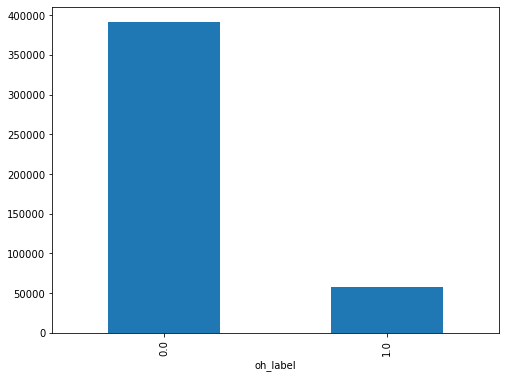

In [8]:
#Exploring the data
fig = plt.figure(figsize=(8,6))
df.groupby('oh_label').Text.count().plot.bar(ylim=0)
plt.show()